# Preprocessing data (functionized)

## 1. Preparations
### 1.1 Import required packages

In [177]:
# import rasterio
try:
    import rasterio
except:
    %pip install rasterio
    import rasterio

import rasterio.features
import rasterio.warp
from rasterio.windows import Window
from rasterio.features import geometry_mask

In [178]:
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json  # for saving patch metadata in JSON format

### 1.2 Set directories and file paths

In [179]:
# input directories
# raster data
gtif_dir = r"D:\Drohne\1_OHB\1_OHB_Normalbetrieb\3_OHB_Juli_2024\Outputs\RGB\GeoTIFF"
# class labels
shp_dir = r"C:\Users\simon\Meine Ablage\Dokumente.GD\FS06 SS24\BACHELORARBEIT\MoSE\data\shapefiles"

# output directories for patches
# as GeoTIFFs
output_gtif_dir = r"D:\MoSE\preprocessing\gtif_outputs"
# as NumpyArrays
output_nparr_dir = r"D:\MoSE\preprocessing\nparr_outputs"
# for JSON metadata
output_json_dir = r"D:\MoSE\preprocessing\json_outputs"

## 2. Create Patches
### 2.1 Set Hyperparameters

In [180]:
# exact paths to files
# raster data
gtif_name = "A01"
gtif_path = gtif_dir + r"\OHB_Abschnitt_01.tif"
# class labels
shp_path = shp_dir + r"\GSK_24_WGS84.shp"

In [181]:
# parameters for patches
PATCH_SIZE = 512 # 512x512 pixel per patch
STRIDE = 256 # 256 pixel overlap between patches

### 2.2 Create the patch loop

In [215]:
# 1. Load the GeoTIFF (orthophoto)
with rasterio.open(gtif_path) as src:
    nparr_data = src.read() # reads raster data of the GeoTIFF as NumPy-Array
    gtif_width, gtif_height = src.width, src.height
    gtif_transform = src.transform  # transformation matrix (whole image)
    gtif_crs = src.crs  # coordinate system
    gtif_meta = src.meta.copy() # original metadata like coordinate system, resolution, datatype
    gtif_bounds = src.bounds

    # 2. Load labels and transform in crs of the orthophoto
    labels = gpd.read_file(shp_path)
    labels = labels.to_crs(gtif_crs)

    # 3. LOOP for patches
    # set patch-id to zero
    patch_id = 0 # unique counter

    # 3.1 Initialize empty list for storing patch metadata
    patch_metadata_list = []

    # Loop over the image in steps of STRIDE (overlapping patches if STRIDE < PATCH_SIZE)
    for y in range(0, gtif_height, STRIDE): # vertical movement y (start point: 0, end point: height, steps: STRIDE)
        for x in range(0, gtif_width, STRIDE): # horizontal movement x (start point: 0, end point: width, steps: STRIDE)
            
            # 3.1 Define window (patch)
            window = Window(x, y, PATCH_SIZE, PATCH_SIZE) 
            # defines a patch/window with origin (x, y) and a size of PATCH_SIZExPATCH_SIZE 

            # 3.2 Calculate the transformation matrix for this patch
            patch_transform = src.window_transform(window) 
            # this transformation matrix describes how the pixel coordinates of this window can be converted into 
            # the world coordinates of the image (geocoordinates)

            # 3.3 Extract raster data for the patch
            patch_data = src.read(window=window, indexes=[1, 2, 3]) # read only the first three bands (ignore the fourth band)
            # patch_data should be an array with shape [bands, PATCH_SIZE, PATCH_SIZE]
            
            # 3.4 Skip incomplete patches
            # if the calculated patch is partially outside the image boundaries (patch is smaller than PATCH_SIZE),
            # skip the patch to avoid errors
            if patch_data.shape[1] < PATCH_SIZE or patch_data.shape[2] < PATCH_SIZE:
                continue

            # 3.5 Check for "NoData" pixels in bands 0-2 (value = 255)
            nodata_value = 255  # Define the NoData value
            nodata_pixels = (patch_data == nodata_value).sum()  # Count NoData pixels across all bands
            total_pixels = PATCH_SIZE * PATCH_SIZE * patch_data.shape[0]  # Total pixels in the patch (3 bands)
            nodata_ratio = nodata_pixels / total_pixels # calculate the nodata-ratio
            # Skip patch if more than 50% of the pixels are NoData
            if nodata_ratio > 0.5:
                continue

            # 4. Create masks for the labels
            
            # 4.1 Calculate geographical coordinates (boundaries) of current patch 
            patch_bounds = rasterio.windows.bounds(window, gtif_transform) # with orthophoto transformation matrix 
            
            # 4.2 Filters label polygons which are inside the patch
            patch_labels = labels.cx[ # labels.cx (pandas) > filters geometries by coordinates
                patch_bounds[0]:patch_bounds[2],  # min_x:max_x
                patch_bounds[1]:patch_bounds[3],  # min_y:max_y
            ]

            # 4.3 Create mask
            mask = None # Reset mask
            if not patch_labels.empty: # if there are any labels in this patch 
                mask = geometry_mask( # creates binary mask (1 = inside polygon, 0 = outside)
                    [geom for geom in patch_labels.geometry], # list of geometries
                    transform=patch_transform, # transform matrix for this patch
                    invert=True, # pixel inside the geometries (labels) = 1, pixel outside (background) = 0
                    out_shape=(PATCH_SIZE, PATCH_SIZE), # size of the mask
                ).astype(np.uint8) # convert into uint8 (compatible with GeoTIFF)

            # 5. Save patch
            # 5.1 Save meta data of the patch
            patch_meta = gtif_meta.copy()
            patch_meta.update({
                "height": PATCH_SIZE,
                "width": PATCH_SIZE,
                "transform": patch_transform,
                "count": 4 if mask is not None else 3, # update to match the number of bands in patch_data
                "blockxsize": 256, # block width
                "blockysize": 256, # block height
                "tiled": True, # tiling-activation
                "compress": "DEFLATE",  # Compression optimized for storage space
                "predictor": 2,    
                "dtype": "uint8",     
            })

            # 5.2 Save patch as GeoTIFF
            patch_path = os.path.join(output_gtif_dir, f"{gtif_name}_patch_{patch_id}.tif")
            with rasterio.open(patch_path, "w", **patch_meta) as dst:
                # combine orthophoto data and mask (if existent) into a single GeoTIFF 
                if mask is not None:
                    combined_data = np.zeros((4, PATCH_SIZE, PATCH_SIZE), dtype=np.uint8) # create an empty array with correct shape
                    combined_data[:3, :, :] = patch_data # copy rgb bands into array
                    combined_data[3, :, :] = mask # add mask as band 4
                    dst.write(combined_data)  
                else: # there are no labels in this patch
                    dst.write(patch_data)  # write orthophoto bands (3 bands) 

            # 5.3 Save patch as NumpyArray
            npy_data = {"image": patch_data}
            if mask is not None: # add mask to the dictionary
                npy_data["mask"] = mask
            np.save(os.path.join(output_nparr_dir, f"{gtif_name}_patch_{patch_id}.npy"), npy_data)

            # 5.4 Save patch metadata to list
            patch_metadata_list.append({
                "patch_id": patch_id,
                "bounds": patch_bounds,
                "transform": patch_transform.to_gdal() # convert affine transform to a list format for JSON
            })
            
            # 6. Logging: Current status
            if patch_id % 100 == 0:
                print(f"{patch_id} patches created...")

            # 7. Loop for the next patch 
            patch_id += 1

    # 8. Save all patch metadata to a JSON file after loop
    metadata_path = os.path.join(output_json_dir, f"{gtif_name}_metadata.json")
    with open(metadata_path, "w") as json_file:
        json.dump(patch_metadata_list, json_file, indent=4)
    
    # 9. END MESSAGE
    print(f"{patch_id} patches have been created and saved as GeoTIFF in {output_gtif_dir} and as NumpyArray in {output_nparr_dir}. Metadata saved as JSON-file in {output_json_dir}")

0 patches created...
100 patches created...
200 patches created...
300 patches created...
400 patches created...
500 patches created...
600 patches created...
700 patches created...
800 patches created...
900 patches created...
1000 patches created...
1100 patches created...
1200 patches created...
1300 patches created...
1400 patches created...
1500 patches created...
1600 patches created...
1700 patches created...
1800 patches created...
1900 patches created...
2000 patches created...
2100 patches created...
2200 patches created...
2300 patches created...
2400 patches created...
2500 patches created...
2600 patches created...
2700 patches created...
2800 patches created...
2900 patches created...
3000 patches created...
3100 patches created...
3200 patches created...
3300 patches created...
3358 patches have been created and saved as GeoTIFF in D:\MoSE\preprocessing\gtif_outputs and as NumpyArray in D:\MoSE\preprocessing\nparr_outputs. Metadata saved as JSON-file in D:\MoSE\preproces

In [ ]:
patch_labels

,GSK_Code,Elementtyp,Bemerkung,Shape_Leng,Shape_Area,s_length_m,s_area_m2,geometry


### 2.3 OPTIONAL: Plot patches 
1. Plot the image data (orthophoto) of a patch saved as GeoTIFF

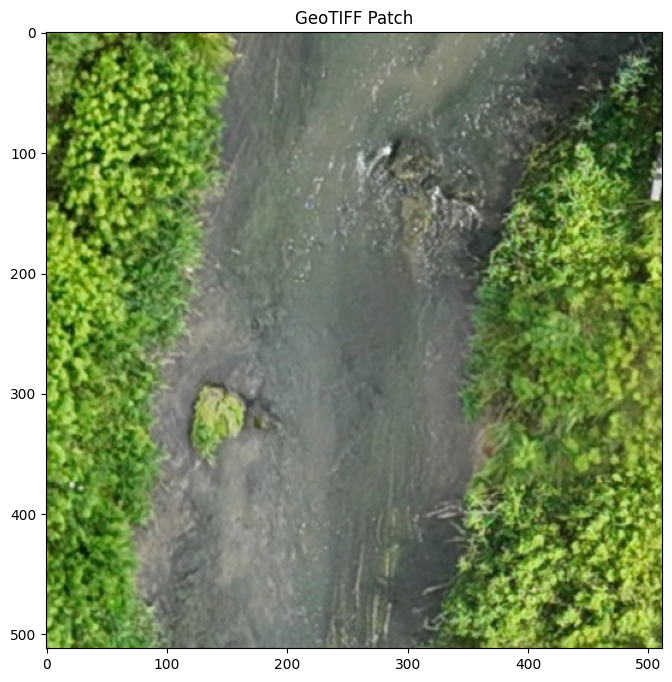

In [239]:
# Hyperparameter: Wich patch (id)?
TEST_PATCH_ID = 1089
# TEST_PATCH_ID = 200

# test GeoTIFF patch path
test_gtif = output_gtif_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.tif"

# load test GeoTIFF patch and plot the image data (RGB = first three bands)
with rasterio.open(test_gtif) as src:
    patch_image_data = src.read([1, 2, 3])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(patch_image_data.transpose(1, 2, 0))  # transpose for RGB
    ax.set_title("GeoTIFF Patch")
    plt.show()

2. Plot the image data of a patch saved as NumpyArray

In [241]:
# test NumpyArray patch path
test_nparr = output_nparr_dir + f"/{gtif_name}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (dtype = object > saved as dictionary)
patch_data_npy = np.load(test_nparr, allow_pickle=True)
# print(patch_data_npy) 
# print(patch_data_npy.dtype) # structure of a dict
# print(patch_data_npy.shape)

In [242]:
# Load the image data of the NumpyArray
test_image_data_npy = patch_data_npy.item().get("image") # key "image"
# test_image_data_npy

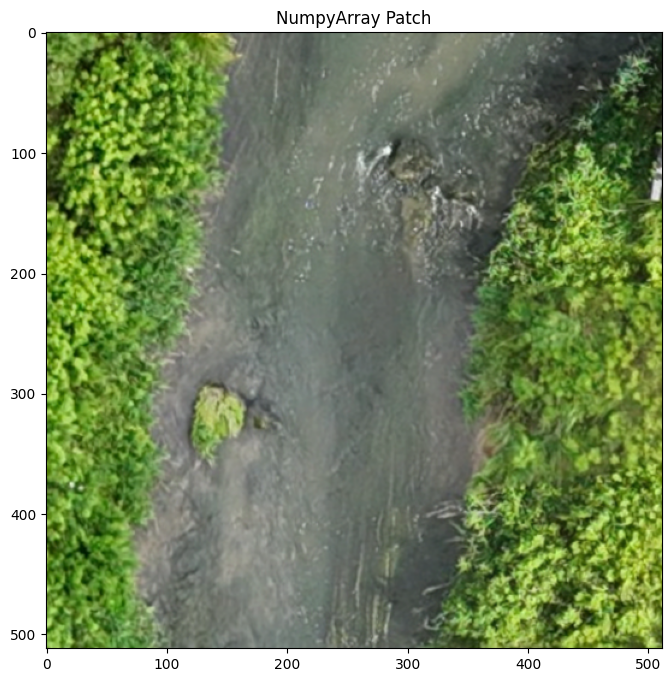

In [243]:
# plot the image data
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_image_data_npy.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("NumpyArray Patch")
plt.show()

3. Plot masks (if existent) from the NumpyArray

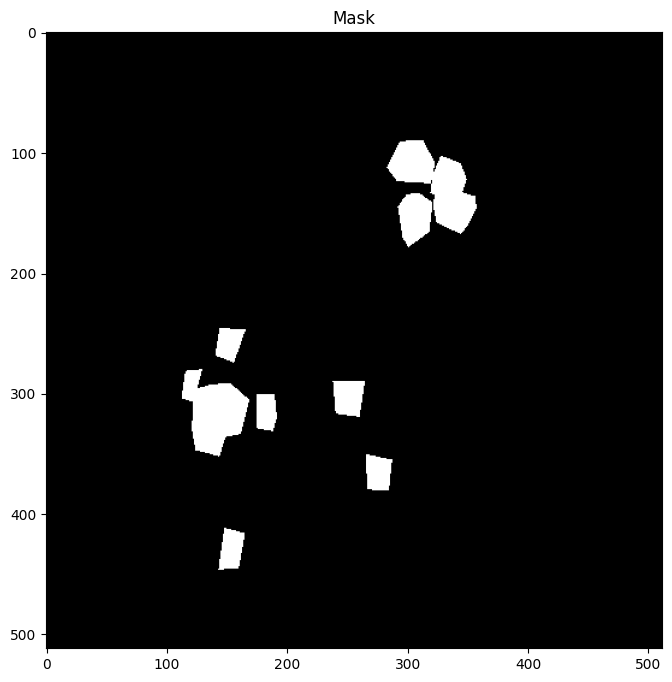

In [244]:
# load the "mask" data of the NumpyArray
test_mask_data_npy = np.load(test_nparr, allow_pickle=True).item().get("mask")  

if test_mask_data_npy is not None:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(test_mask_data_npy, cmap="gray")  
    ax.set_title("Mask")
    plt.show()
else:
    print("There aren't any labels in this patch!")


4. Plot mask together with corresponding patch

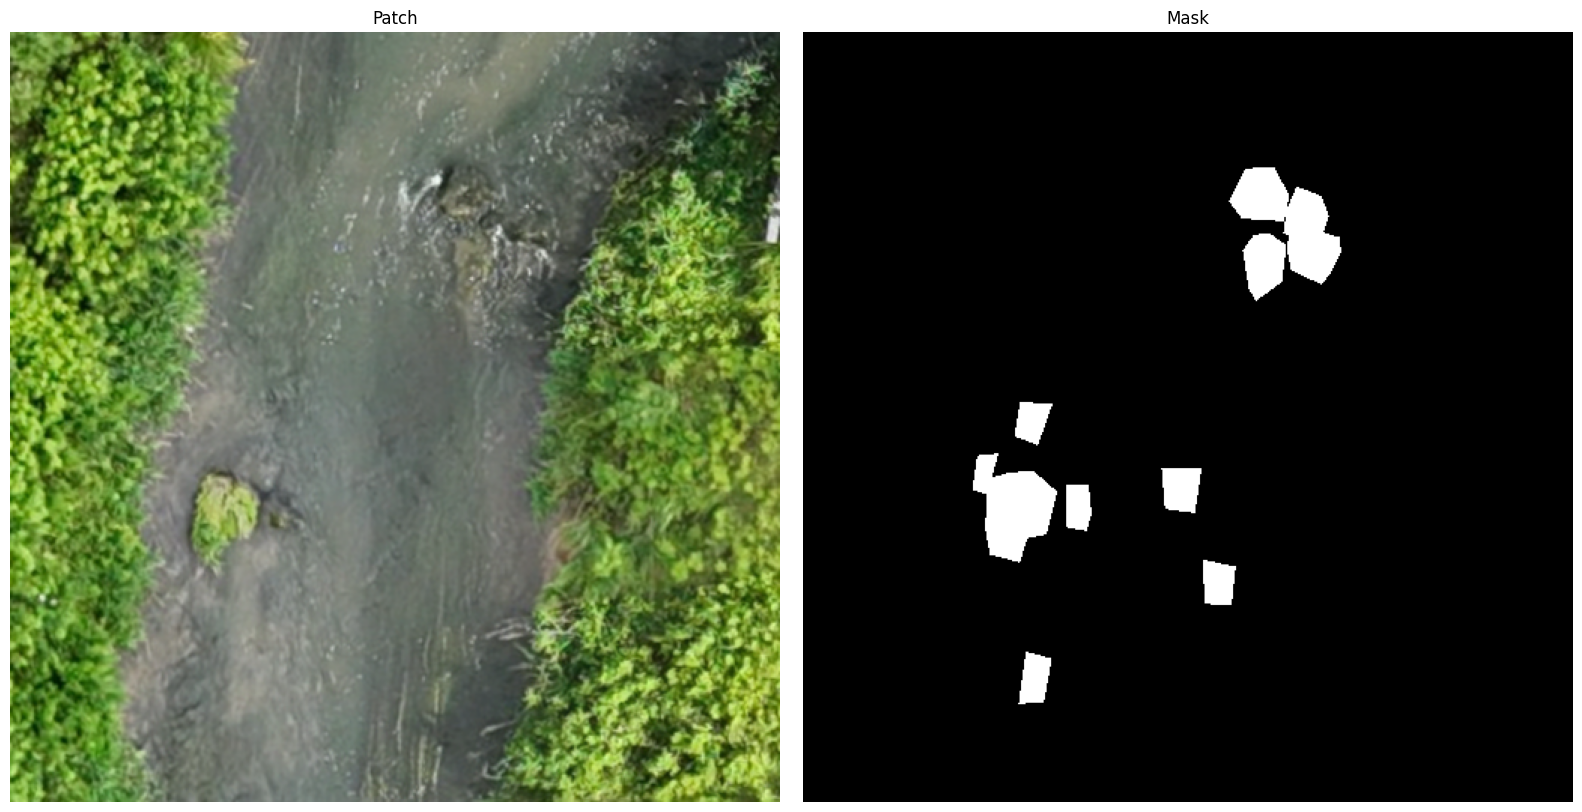

In [245]:
if test_mask_data_npy is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot Patch
    axes[0].imshow(test_image_data_npy.transpose(1, 2, 0)) 
    axes[0].set_title("Patch")
    axes[0].axis('off')

    # Plot mask
    axes[1].imshow(test_mask_data_npy, cmap="gray") 
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("There aren't any labels in this patch!")


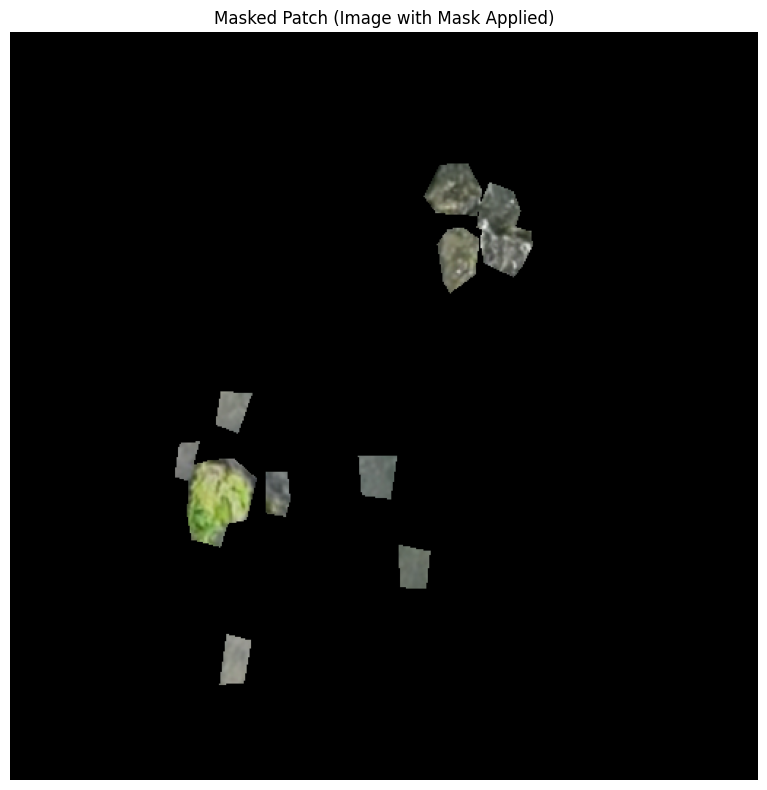

In [247]:
# apply the mask 
if test_mask_data_npy is not None:
    
    # show only image parts within the mask
    masked_image = np.zeros_like(test_image_data_npy)  # empty Array with the same shape like the patch
    for i in range(3):  # for three RGB channels    
        masked_image[i] = np.where(test_mask_data_npy > 0, test_image_data_npy[i], 0)  # apply the mask

    # plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # show overlayed image
    ax.imshow(masked_image.transpose(1, 2, 0))  # Transponieren für RGB-Darstellung
    ax.set_title("Masked Patch (Image with Mask Applied)")
    ax.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("There aren't any labels in this patch!")

5. Plot mask from the GeoTIFF

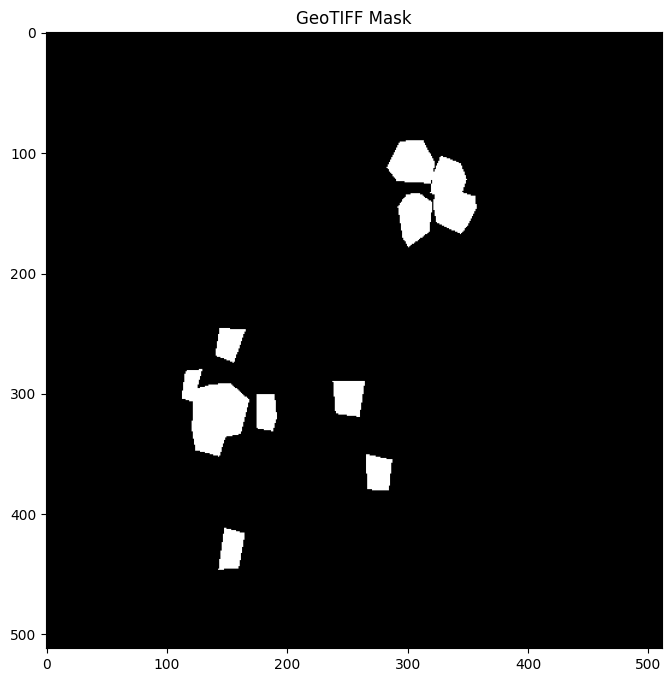

In [248]:
# load test GeoTIFF patch and plot the mask data (fourth band)
with rasterio.open(test_gtif) as src:
    # Check how many bands are available
    num_bands = src.count

    if num_bands >= 4:  # Check if a fourth band (mask) exists
        patch_mask_data = src.read(4)  # Read the fourth band
        
        # Plot the mask
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(patch_mask_data, cmap="gray")  # Display the mask in grayscale
        ax.set_title("GeoTIFF Mask")
        plt.show()

    else:
        print("There aren't any labels in this patch!")

6. Load and show meta data (JSON)

In [253]:
test_metadata = output_json_dir + f"/{gtif_name}_metadata.json"

# open and read meta data
with open(test_metadata) as json_file:
    metadata = json.load(json_file)

# show meta data of first two patches
print("meta data of first two patches:")
for patch in metadata[:2]:
    print(f"Patch ID: {patch['patch_id']}")
    print(f"Bounds: {patch['bounds']}")
    print(f"Transform: {patch['transform']}")
    print("-" * 30)

# show meta data to patch TEST_PATCH_ID
print("meta data of selected patch:")
print(metadata[TEST_PATCH_ID]['patch_id'])
print(metadata[TEST_PATCH_ID])



meta data of first two patches:
Patch ID: 0
Bounds: [11.265079558766594, 48.75042967464041, 11.265246644334594, 48.750540169360406]
Transform: [11.265079558766594, 3.2633900000001453e-07, 0.0, 48.750540169360406, 0.0, -2.1580999999988398e-07]
------------------------------
Patch ID: 1
Bounds: [11.265163101550593, 48.75042967464041, 11.265330187118593, 48.750540169360406]
Transform: [11.265163101550593, 3.2633900000001453e-07, 0.0, 48.750540169360406, 0.0, -2.1580999999988398e-07]
------------------------------
meta data of selected patch:
1089
{'patch_id': 1089, 'bounds': [11.265330187118593, 48.748717006480405, 11.265497272686593, 48.74882750120041], 'transform': [11.265330187118593, 3.2633900000001453e-07, 0.0, 48.74882750120041, 0.0, -2.1580999999988398e-07]}


### 2.4 OPTIONAL: Check the orthophoto

In [256]:
# check meta data
gtif_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 17270,
 'height': 25023,
 'count': 4,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(3.2633900000001453e-07, 0.0, 11.263241617518593,
        0.0, -2.1580999999988398e-07, 48.750540169360406)}

In [255]:
# check geometrical properties
gtif_crs, gtif_bounds, gtif_height, gtif_width

(CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 BoundingBox(left=11.263241617518593, bottom=48.74513995573041, right=11.268877492048594, top=48.750540169360406),
 25023,
 17270)